In [1]:
#Import all the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno #library to visualize missing data
import re#library for regular expression
import auto_ml as aml
import cPickle

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler,Normalizer,StandardScaler,RobustScaler,LabelEncoder,OneHotEncoder 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [2]:
#Function to read data to dataframe

def read_file_to_df(filepath):
    
    df = pd.DataFrame()#define an empty dataframe
    
    try:
        if filepath.endswith(".csv"):
            df = pd.read_csv(filepath)
            df_loaded_ind=True

        elif (filepath.endswith(".xls") | filepath.endswith(".xlsx")):
            df = pd.read_excel(filepath)
            df_loaded_ind=True

        else:
            print('Invalid file type')
            print('\n')
            df_loaded_ind = False
    except:
        print('Invalid file path')
        print('\n')
        df_loaded_ind = False
        
                
    return df_loaded_ind,df

In [3]:

while(True):
    filepath             = input('Please provide the file path for the data : ')
    print('\n')
    data_loaded_ind,data = read_file_to_df(filepath)
    if data_loaded_ind:
        print('Data is successfully loaded!!')
        break
    else:
        print('Error loading dataset!! Try again...')
    print('\n')


Please provide the file path for the data : housing_price.csv


Data is successfully loaded!!


In [4]:
print('Take a quick look at your data...\n')
data.head()


Take a quick look at your data...



,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
before_dup_row = data.shape[0]
print("Checking for duplicate rows in the data and dropping if any...")
print("\n")
data.drop_duplicates(inplace=True)
after_dup_row = data.shape[0]
dropped_row_count=(before_dup_row - after_dup_row)
if dropped_row_count > 0:
    print("{} duplicate rows were dropped...".format(dropped_row_count))
else:
    print("No duplicate entries found!")

Checking for duplicate rows in the data and dropping if any...


No duplicate entries found!


In [6]:
def duplicate_columns(frame):
    groups = frame.columns.to_series().groupby(frame.dtypes).groups
    dups = []

    for t, v in groups.items():

        cs = frame[v].columns
        vs = frame[v]
        lcs = len(cs)

        for i in range(lcs):
            iv = vs.iloc[:,i].tolist()
            for j in range(i+1, lcs):
                jv = vs.iloc[:,j].tolist()
                if iv == jv:
                    dups.append((cs[i],cs[j]))
                    break

    return dups

In [7]:
print("Checking for duplicate columns in the data and dropping if any..")
print('\n')
dup_cols_pair=duplicate_columns(data)
if dup_cols_pair:
    print("Here is the list of duplicate columns pair : ",dup_cols_pair)
    print('\n')
    print("Dropping first column of all duplicate columns pairs..")
    print('\n')
    dup_col_drop=list(set([i[0] for i in dup_cols_pair]))
    data.drop(dup_col_drop,axis=1,inplace=True)
    print("Here is the list of columns that were dropped : ",dup_col_drop)
    print("\n")
    print("Remaining columns in the dataset are : ",data.columns.tolist())
else:
    print("No duplicate columns found!")


Checking for duplicate columns in the data and dropping if any..


No duplicate columns found!


In [8]:
print('The data types of every feature are as follows:\n')

g = data.columns.to_series().groupby(data.dtypes).groups
{k.name: v for k, v in g.items()}


The data types of every feature are as follows:



{'int64': Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
        'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
        'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
        'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
        'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
        'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
       dtype='object'),
 'float64': Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object'),
 'object': Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
        'BsmtQual', 'BsmtCond', 'Bsm

Plotting the features with integer data types..


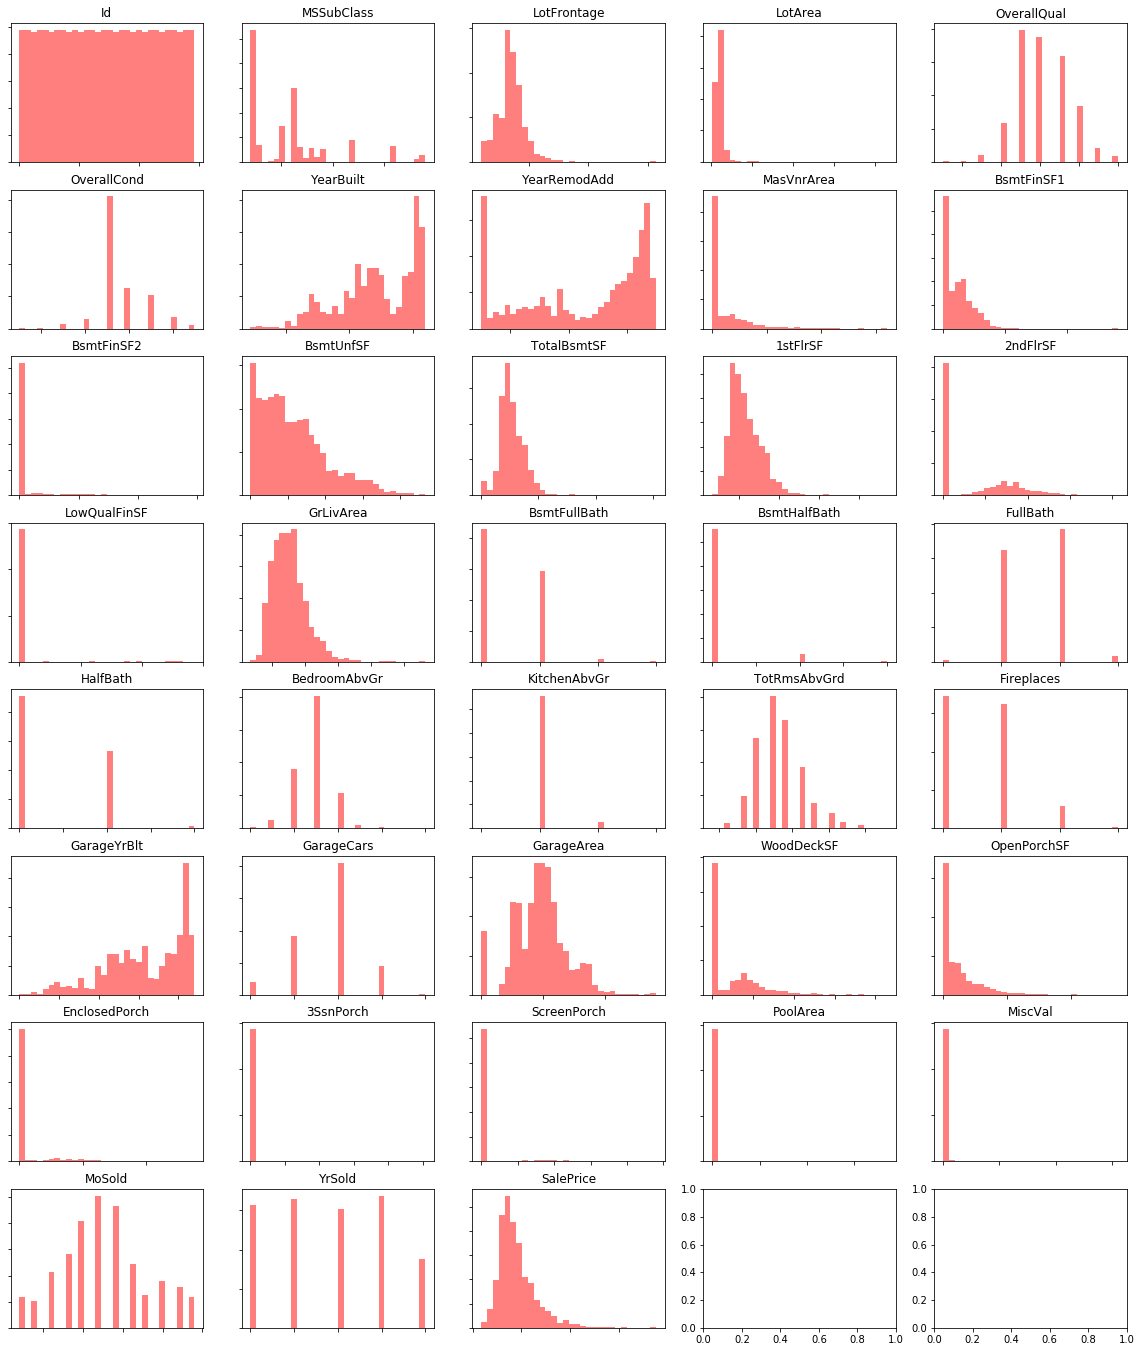

In [9]:
data_int = data.select_dtypes(include=['int64','int32','float64','float32'])
int_columns = data_int.columns.tolist()
print('Plotting the features with integer data types..')
no_cols = 5
no_rows = int(np.ceil(len(int_columns) / no_cols))
fig, axes = plt.subplots(ncols=no_cols,nrows=no_rows, figsize=(20,3*no_rows))
axes = axes.flatten()

for i in range(len(int_columns)):#(no_rows*no_cols):
    axes[i].hist(data_int[int_columns[i]].dropna(), bins=30,facecolor='r',alpha=0.5)
    axes[i].set_title(int_columns[i])
    plt.setp(axes[i].get_xticklabels(), visible=False)
    plt.setp(axes[i].get_yticklabels(), visible=False)


In [10]:
#Function to validate column names
def validate_columns(df,columnlist):
    
    invalid_columns = []
    if columnlist:
        invalid_columns = [col for col in columnlist if col not in df.columns.tolist()]
                
    return invalid_columns

In [11]:
#Function to convert datatype of mentioned columns to corresponding mentioned types
def data_type_converter(df,column_names=[],to_types=[]):
    
    if (isinstance(column_names, list) & isinstance(to_types, list)):#check if passed item is in list format

        for col,typ in zip(column_names,to_types):
            if typ == 'datetime64[ns]':
                try:
                    df[col] = df[col].astype(typ)
                except:
                    invalid_frmt=True
                    while(invalid_frmt==True):
                        print("Unable to convert {} to datetime format".format(col))
                        frmt=input('Please specify the datetime format of {} feature : '.format(col))
                        print("\n")
                        try:
                            input_taken=False
                            for i in range(len(df[col])):
                                if df[col][i].startswith('0000'):
                                    if (input_taken==False):
                                        print("Some of the values in {} starts with '0000' which is invalid!\n".format(col))
                                        rep_val=input("Please enter a date in the same format as {} to replace values that start with '0000'".format(col))
                                        input_taken=True
                                    df[col][i] = df[col][i].replace(df[col][i],rep_val)

                            df[col]=pd.to_datetime(data[col], format=frmt)
                            invalid_frmt=False
                        except Exception as e:
                            print(e)
                            #print("Oops!! Invalid format entered")
            else:
                df[col] = df[col].astype(typ)

    return df

In [12]:
print('Please make sure that all the features are in int/float/string/category/boolean/timestamp format')
print('\n')
print("Please note that accepted type for all date/timestamp feature conversion is : 'datetime64[ns]'\n")
print("Example for date format: If your date is '2018-07-02-16.07.13.624406',format should be '%Y-%m-%d-%H.%M.%S.%f'")
print('\n')
type_change_ind = (input('Would you like to change the data type of any feature?-Y/N')).upper()
print('\n')
if type_change_ind == 'Y':
    while(True):
        cols_for_type_change=[]
        to_type_list=[]
        print('Enter the features for which you wish to change the data types, separated by comma')
        cols_for_type_change = [x for x in input().split(',')]
        print('\n')
        invalid_col_names = validate_columns(data,columnlist = cols_for_type_change)
        if invalid_col_names:
            print('Warning!! Some of the feature names you have entered are incorrect. List of incorrectly entered features are : ',invalid_col_names)
            print('Please verify..')
            print('\n')
        else:
            before_data_type = data[cols_for_type_change].dtypes.tolist()
            break 
    print('Enter the type to which you would like to change the data types, in the same sequence as the features, separated by comma')
    to_type_list         = [x for x in input().split(',')]
    print('\n')
    data = data_type_converter(data,column_names=cols_for_type_change,to_types=to_type_list)
    after_data_type = data[cols_for_type_change].dtypes.tolist()
    print('The changed data types are as follows :\n') 
    display(pd.DataFrame(list(zip(cols_for_type_change, before_data_type, after_data_type)),columns=['Features','Before', 'After']))


Please make sure that all the features are in int/float/string/category/boolean/timestamp format


Please note that accepted type for all date/timestamp feature conversion is : 'datetime64[ns]'

Example for date format: If your date is '2018-07-02-16.07.13.624406',format should be '%Y-%m-%d-%H.%M.%S.%f'


Would you like to change the data type of any feature?-Y/Ny


Enter the features for which you wish to change the data types, separated by comma
Id


Enter the type to which you would like to change the data types, in the same sequence as the features, separated by comma
object


The changed data types are as follows :



,Features,Before,After
0,Id,int64,object


In [13]:
#Function to get the ratio of null values in columns of dataset in descending order
def get_null_count(df):
   
    na_count=df.isnull().sum().sort_values(ascending=False)/len(df)#columnwise ratio of null values
    na_count=na_count[na_count>0]#choose only the columns whic have null values

    return na_count
        

In [14]:
#Function to visualize the null value distribution
def visualize_null_count(df,null_count):

    filtered_data = msno.nullity_filter(df,  filter='bottom',n=len(null_count))
    msno.matrix(filtered_data,labels=True,figsize=(35, 15))
        



Checking for null values in the dataset...


Below are the features that contain null values :
 PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageCond      0.055479
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
BsmtExposure    0.026027
BsmtFinType2    0.026027
BsmtFinType1    0.025342
BsmtCond        0.025342
BsmtQual        0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
dtype: float64


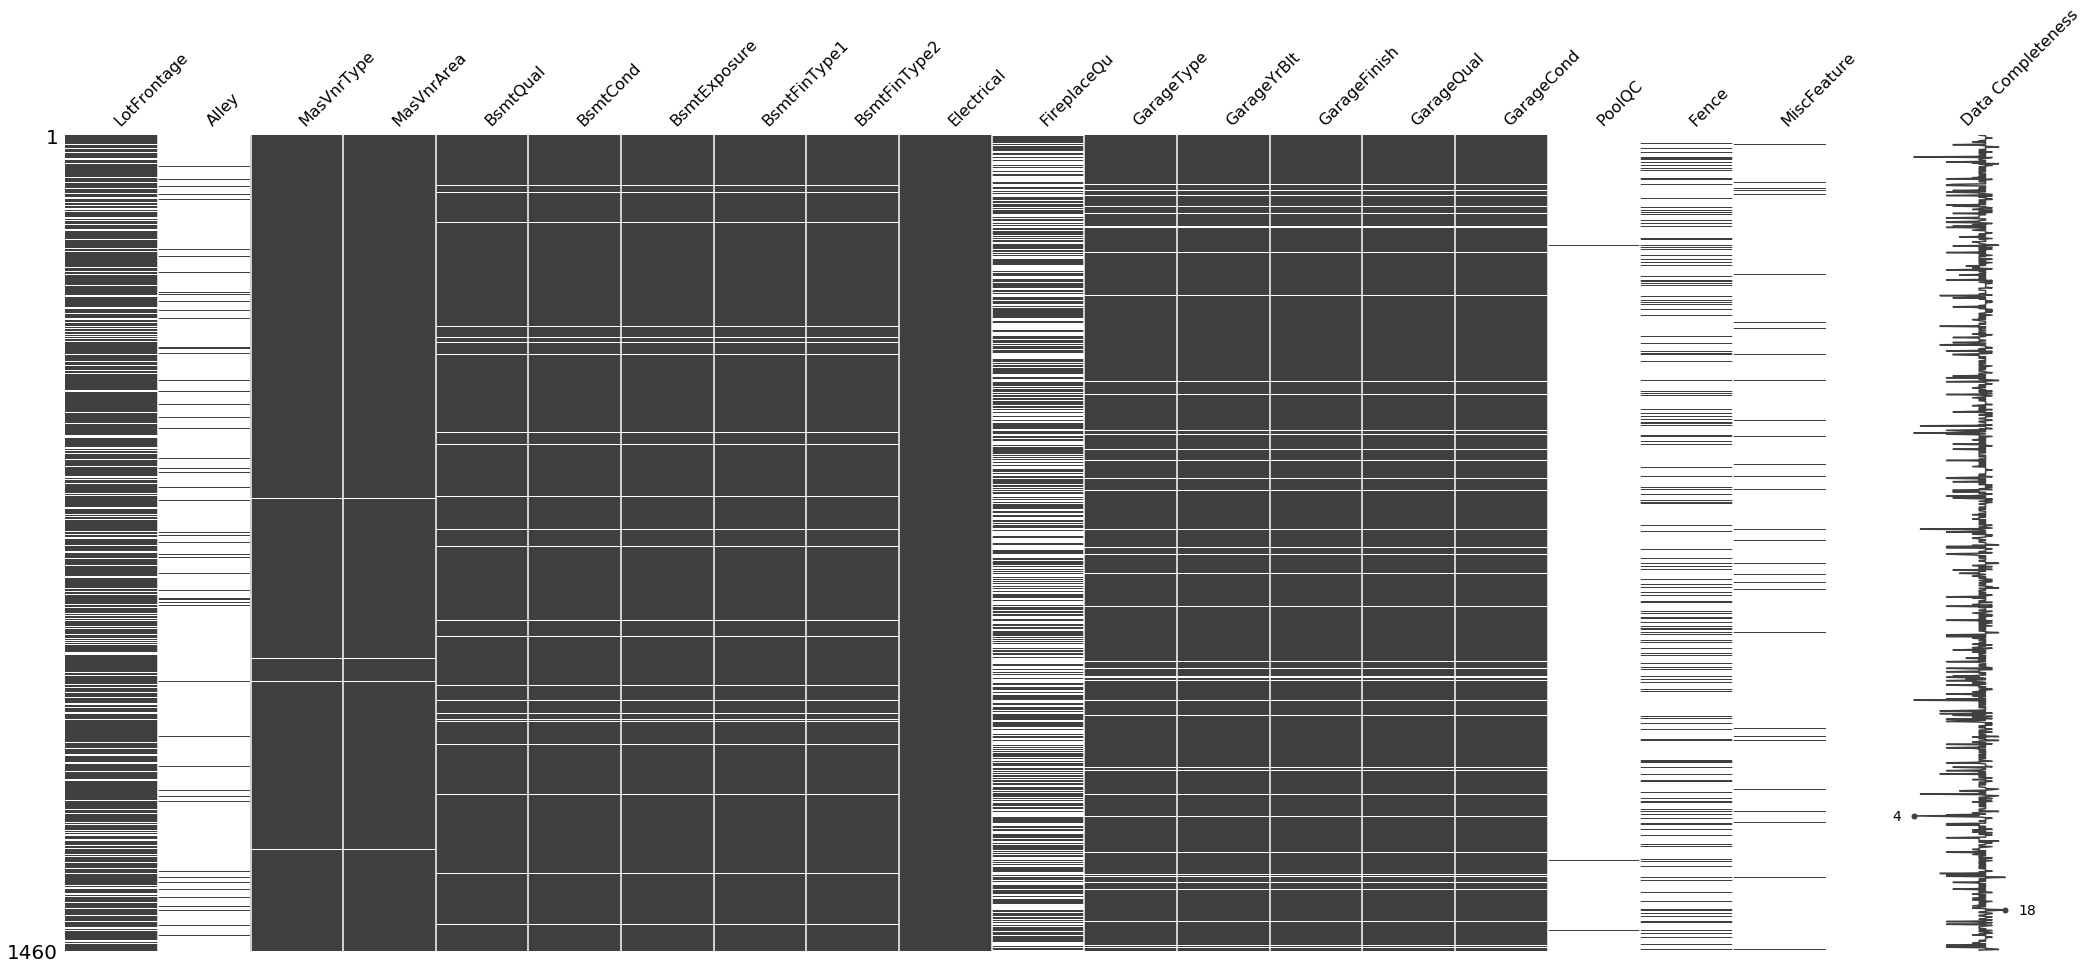

Press enter to continue


''

In [15]:
#input('Press enter to continue ...')
print('\n')
print('Checking for null values in the dataset...')
print('\n')
if data.isnull().values.any():
    null_count = get_null_count(data)
    print('Below are the features that contain null values :\n', null_count)
    visualize_null_count(data,null_count)
    plt.show()
else:
    print('There is not any null value in the dataset!!')

input('Press enter to continue')

In [16]:
#Function to drop desired columns
def drop_columns(df,columnlist=[]):
    if columnlist:
        df.drop(columnlist,axis=1,inplace=True)#Drop all the columns in the list
    return df

In [17]:

drop_col_ind = (input('Would you like to drop any feature?-Y/N')).upper()
print('\n')
if drop_col_ind == 'Y':
    while(True):
        drop_null_column_list = []
        print('Enter the features you wish to drop, separated by comma :')
        drop_null_column_list = [x for x in input().split(',')]
        print('\n')

        if drop_null_column_list:
            invalid_col_names = validate_columns(data,columnlist = drop_null_column_list)
            if invalid_col_names:
                print('Warning!! Some of the feature names you have entered are incorrect. List of incorrectly entered features are : ',invalid_col_names)
                print('Please verify..')
                print('\n')
            else:
                break 

    data = drop_columns(data,columnlist=drop_null_column_list)
    print('Specified features are successfully dropped...')
    print('\n')
    print('Existing features in the dataset are: ', data.columns.tolist())
    print('\n')
    input('Press enter to continue')

Would you like to drop any feature?-Y/Nn




In [18]:
#Function to impute missing values
def impute_missing(df, drop_nans):  

    #drop the rows containing null values if drop_nans is set to True
    if drop_nans:
        df.dropna(inplace=True)
    else:
        null_features = get_null_count(df).index.tolist()
        print("Here is the list of features containing null values : \n",null_features)
        print("\n")
        print("For each of these features, please specify how you would like to impute missing values,separated by commas in the same order as the above list\n")
        print("You can enter 'mean' to replace missing values with mean of the feature, 'mode' to replace with mode or 'others' to replace with desired value.\n")
        print("NOTE :\n")
    
        for i,j in zip(null_features,df[null_features].dtypes):
            print("Datatype of {} : {}".format(i,j))
        
        imputation = [x for x in input().split(',')]
        print("\n")
        print("Imputing missing values...")
        print("\n") 
        for col,imp in zip(null_features,imputation):
            if imp == 'mean':
                column_median = df[col].median()
                df[col].fillna(column_median, inplace=True)
            elif imp == 'mode':
                column_mode = df[col].mode()[0]
                df[col].fillna(column_mode, inplace=True)
            elif imp == 'others':
                prev_type=df[col].dtype
                print("For {} :".format(col))
                while (True):
                    imp_oth = input(" Please specify the value to replace null values : ")
                    if not imp_oth == '':
                        break
                print("\n") 
                df[col].fillna(imp_oth, inplace=True)
                after_type=df[col].dtype
                if (prev_type != after_type):
                    df[col] = df[col].astype(prev_type)
                    

                
    if df.isnull().values.any():
        print('Error in replacing/dropping missing data!!')
    else:
        if drop_nans:
            print('Missing values are successfully dropped!!')   
        else:
            print('Missing values are successfully replaced!!')
    
    return df
    

In [19]:
if data.isnull().values.any():
    drop_na_rows = (input('Do you wish to drop all rows with null values?-Y/N')).upper()
    print('\n')
    drop_nans = False
    if drop_na_rows == 'Y':
        drop_nans = True

    data = impute_missing(data, drop_nans=drop_nans)
    
    print('\n')
    input('Press enter to continue')


Do you wish to drop all rows with null values?-Y/Nn


Here is the list of features containing null values : 
 ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage', 'GarageCond', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual', 'MasVnrArea', 'MasVnrType', 'Electrical']


For each of these features, please specify how you would like to impute missing values,separated by commas in the same order as the above list

You can enter 'mean' to replace missing values with mean of the feature, 'mode' to replace with mode or 'others' to replace with desired value.

NOTE :

Datatype of PoolQC : object
Datatype of MiscFeature : object
Datatype of Alley : object
Datatype of Fence : object
Datatype of FireplaceQu : object
Datatype of LotFrontage : float64
Datatype of GarageCond : object
Datatype of GarageType : object
Datatype of GarageYrBlt : float64
Datatype of GarageFinish : object
Datatype of Gara

In [20]:
#Function to separate data and target variable 
def separate_target(df_raw,target_name):
    
    target             = df_raw[target_name]#target variable 
    df                 = df_raw.drop(target_name,axis=1)#data without target variable
    target_is_separate = True
      
    return df,target,target_is_separate


In [21]:
def separate_cont_and_cat_features(df):
    
    categorical_features = df.select_dtypes(include=['object','bool','category']).columns.tolist()
    continuous_features  = df.select_dtypes(include=['number']).columns.tolist()
    date_features        = df.select_dtypes(include=['datetime64[ns]']).columns.tolist()
    
    return continuous_features,categorical_features,date_features
    

In [22]:
#Function to splite timestamp/date column into sub features
def date_splitter(df, fldname):
    
    #convert the specified feature to timestamp format if not already
    fld = df[fldname] 
    #if not np.issubdtype(fld.dtype, np.datetime64):
        #df[fldname] = fld = pd.to_datetime(fld,infer_datetime_format=True)
        
    targ_pre = re.sub('[Dd]ate$', '', fldname)#substitute the phrase 'date' by spaces in the original field name
    
    #obtain different sub features for the date column
    for n in ('Year', 'Month',  'Day', 'Hour' ,'Minute','Second'):
        #if n in ['Hour' ,'Minute','Seconds']:
        df[targ_pre+n] = getattr(fld.dt,n.lower())
        if n in ['Hour' ,'Minute','Second']:
            if any(df[targ_pre+n] > 0):
                #df[targ_pre+n]=df[targ_pre+n].astype('str')    
                df[targ_pre+n]=df[targ_pre+n].astype('category')
            else:
                df.drop(targ_pre+n,axis=1,inplace=True)
        else:
            df[targ_pre+n]=df[targ_pre+n].astype('str')    
            df[targ_pre+n]=df[targ_pre+n].astype('category')

    return df

In [23]:
#Function to convert date field to its Julian format
def Juliandtconv(df,fldname):
    
    #convert the specified feature to timestamp format if not already
    #df[fldname]=pd.to_datetime(df[fldname],infer_datetime_format=True)
    
    df[fldname] = df[fldname].apply(lambda x: x.to_julian_date())#convert to julian format
            
    return  df

In [24]:
#Function to concatenate data and target variable 
def concatenate_target(df,target):
    target_is_separate=False
    return (pd.concat([df,target],axis=1)),target_is_separate


In [25]:
target_name    = input('Please enter the target feature :')
while(True):
    invalid_target_name = validate_columns(data,columnlist = [target_name])
    if invalid_target_name:
        target_name = input('Please verify the target feature and re-enter :')
    else:
        break 

Please enter the target feature :SalePrice


In [26]:

continuous_features,categorical_features,date_features = separate_cont_and_cat_features(data)

if date_features:
    print("Transforming date features in the data...")
    print('\n')
    print("The date features in the dataset are : ", date_features)
    print('\n')
    
    first_dt_feature=True
    
    for i in date_features:
                  
        
        if i == target_name:
            split_or_julian_ind=''
            print("Please specify whether you would like to convert the target feature,{} to Julian format or retain as it is".format(i))
            while(split_or_julian_ind != 'J' and split_or_julian_ind != 'R'):
                split_or_julian_ind=(input("Enter J to convert to Julian or R to retain existing date format : ")).upper()
            print("\n")
            if split_or_julian_ind == 'J':
                data = Juliandtconv(data,fldname=i)
            elif split_or_julian_ind == 'R':
                pass
        else:
            if first_dt_feature:
                first_dt_feature = False
                allind=(input("Would you like to split all date feaures or convert all date features to Julian format? - Y/N")).upper()
                if allind == 'Y':
                    split_or_julian_ind=''
                    while(split_or_julian_ind != 'S' and split_or_julian_ind != 'J'):
                        split_or_julian_ind=(input("Enter S to split, J to convert to Julian format : ")).upper()
                        print("\n")
            if allind != 'Y': 
                print("Please specify whether you would like to split {} or convert it to Julian format ".format(i))
                split_or_julian_ind=''
                while(split_or_julian_ind != 'S' and split_or_julian_ind != 'J'):
                    split_or_julian_ind=(input("Enter S to split, J to convert to Julian format : ")).upper()
                    print("\n")
            if split_or_julian_ind == 'S':
                data = date_splitter(data, fldname=i)
                data.drop(i,axis=1,inplace=True)
            elif split_or_julian_ind == 'J':
                data = Juliandtconv(data,fldname=i)

          
    print('Date tarnsformed data:\n')
    display(data.head())


In [27]:
#Convert categorical features to numerical
def encoding(df,categorical_features):
    
    df_cat = df[categorical_features]
    #By defaault, convert all the categories to numerical forms using Label encoder
    le = {}
    for i in range(len(df_cat.columns.tolist())):
        le[i] = LabelEncoder()
        df_cat.iloc[:,i] = le[i].fit_transform(df_cat.iloc[:,i].astype(str))

    return df_cat

In [28]:
#if target_is_separate_ind:
#    data,target_is_separate_ind       = concatenate_target(data,target)
continuous_features,categorical_features,date_features = separate_cont_and_cat_features(data)

if categorical_features:
    print('Here is the list of categorical features in the dataset:\n', categorical_features)
    print('\n')
    print('Encoding all categorical featues as numerical...')
    print('\n')
    encoded_data  = encoding(data,categorical_features)
    data          = pd.concat([encoded_data,data[continuous_features+date_features]],axis=1)
    print('Encoded data looks like this: \n',data.head())
    

Here is the list of categorical features in the dataset:
 ['Id', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


Encoding all categorical featues as numerical...


Encoded data looks like this: 
     Id  MSZoning  Street  Alley  LotShape  LandContour  Utilities  LotConfig  \
0    0         3       1      2         3            3          0          4   
1  572         3       1      2         3            3          0          2   
2  683         3       1      2

In [29]:
input('Press enter to see the description of your data')
data.describe().T

Press enter to see the description of your data


,count,mean,std,min,25%,50%,75%,max
Id,1460.0,729.500000,421.610009,0.0,364.75,729.5,1094.25,1459.0
MSZoning,1460.0,3.028767,0.632017,0.0,3.00,3.0,3.00,4.0
Street,1460.0,0.995890,0.063996,0.0,1.00,1.0,1.00,1.0
Alley,1460.0,1.903425,0.394776,0.0,2.00,2.0,2.00,2.0
LotShape,1460.0,1.942466,1.409156,0.0,0.00,3.0,3.00,3.0
LandContour,1460.0,2.777397,0.707666,0.0,3.00,3.0,3.00,3.0
Utilities,1460.0,0.000685,0.026171,0.0,0.00,0.0,0.00,1.0
LotConfig,1460.0,3.019178,1.622634,0.0,2.00,4.0,4.00,4.0
LandSlope,1460.0,0.062329,0.276232,0.0,0.00,0.0,0.00,2.0
Neighborhood,1460.0,12.251370,6.013735,0.0,7.00,12.0,17.00,24.0


In [30]:
#Function to bring all data into same scale
def scale_data(df,scaling_type):  
    
    if scaling_type == 'MinMax':
        scaler = MinMaxScaler()#scales based on minimum and maximum values in dataset
        
    if scaling_type == 'Standardize':
        scaler = StandardScaler()#scales based on mean and standard deviation of dataset setting mean to 0 and standard deviation to 1
        
    if scaling_type == 'Robustscale':
        scaler = RobustScaler()#scales based on interquartile range of data

    return pd.DataFrame(scaler.fit_transform(df),columns=df.columns)


In [31]:
scaling_method = input('Please choose the scaling method: MinMax/Standardize/Robustscale')
print('\n')

data,target,target_is_separate_ind                     = separate_target(data,target_name)

if scaling_method in ['Standardize', 'Robustscale','MinMax']:
    scale      = scaling_method
else:
    print('Invalid scaling method chosen. By default, data is scaled using Min-Max scaler')
    print('\n')
    scale      = 'MinMax'

data,target_is_separate_ind       = concatenate_target(scale_data(data,scaling_type= scale),target)

print('Scaled data :\n')
data.head()


Please choose the scaling method: MinMax/Standardize/Robustscale


Invalid scaling method chosen. By default, data is scaled using Min-Max scaler


Scaled data :



,Id,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,0.000000,0.75,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.208333,...,0.000000,0.111517,0.000000,0.0,0.0,0.0,0.0,0.090909,0.50,208500
1,0.392049,0.75,1.0,1.0,1.0,1.0,0.0,0.5,0.0,1.000000,...,0.347725,0.000000,0.000000,0.0,0.0,0.0,0.0,0.363636,0.25,181500
2,0.468129,0.75,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.208333,...,0.000000,0.076782,0.000000,0.0,0.0,0.0,0.0,0.727273,0.50,223500
3,0.544208,0.75,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.250000,...,0.000000,0.063985,0.492754,0.0,0.0,0.0,0.0,0.090909,0.00,140000
4,0.620288,0.75,1.0,1.0,0.0,1.0,0.0,0.5,0.0,0.625000,...,0.224037,0.153565,0.000000,0.0,0.0,0.0,0.0,1.000000,0.50,250000


In [32]:
#Visualize correlation between various features in dataset
def halfHeatMap_corr(df,figsize_x, figsize_y):

    # Create Correlation df
    corr = df.corr()
    # Plot figsize
    fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))
    # Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)

    # Drop self-correlations
    #dropSelf = np.zeros_like(corr)
    #dropSelf[np.triu_indices_from(dropSelf)] = True
    # Generate heatmap with mask on redundant values with a precision of 2 
    sns.heatmap(corr, cmap=colormap)#, mask=dropSelf)

    plt.show()
    


Plotting correlation between the features...




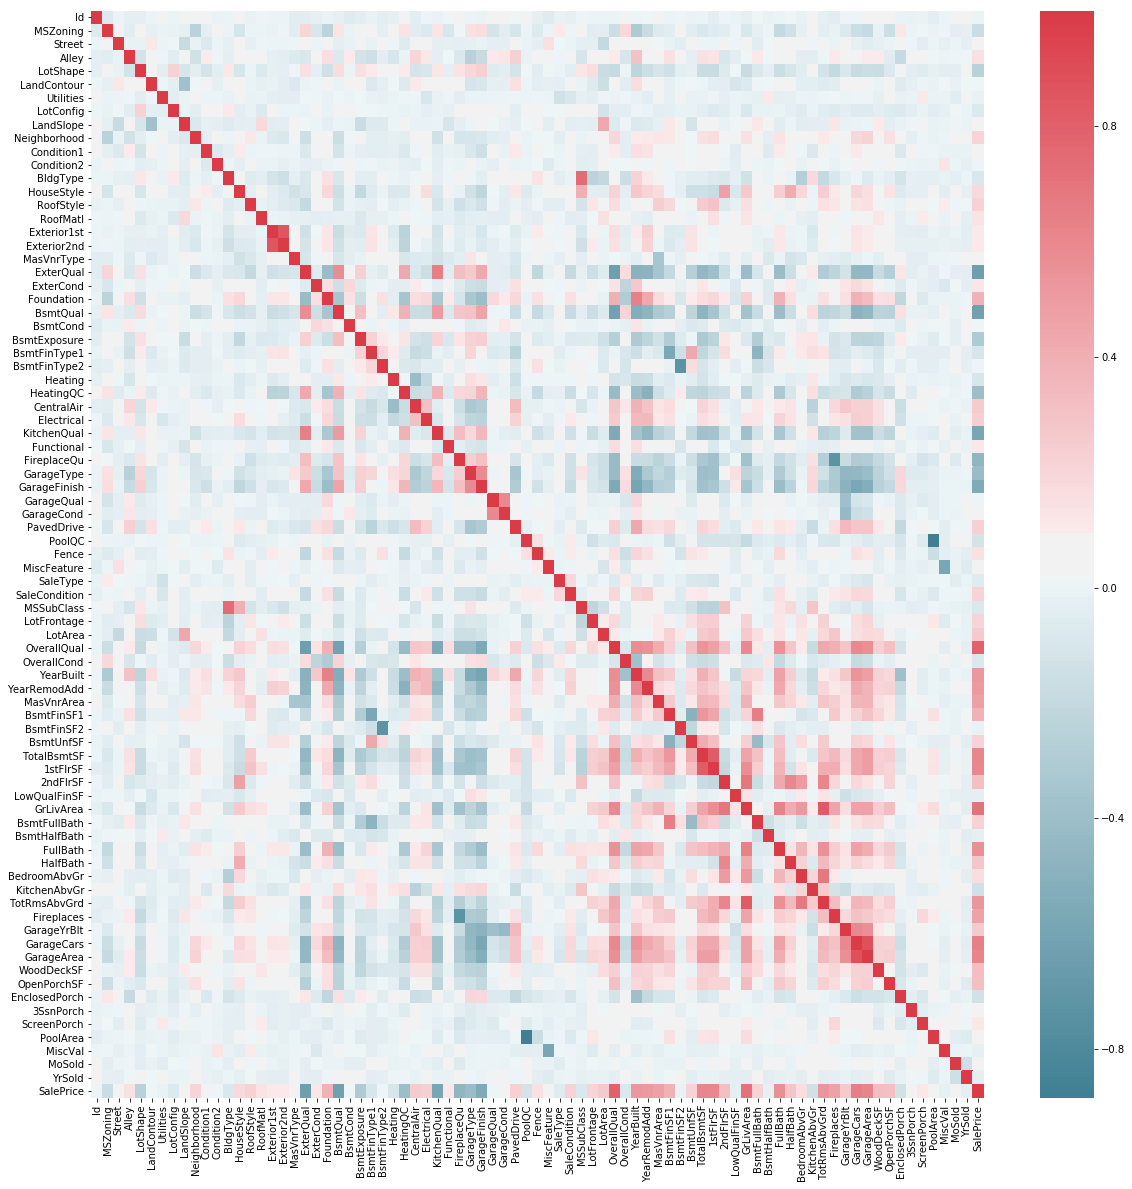

Would you like to increase the plot size for a clear view? - Y/Nn




In [33]:
    
fig_size_x = 20
fig_size_y = 20

while(True):
        print("Plotting correlation between the features...")
        print('\n')
        
        halfHeatMap_corr(data,figsize_x=fig_size_x, figsize_y=fig_size_y)

        fig_size_change_ind = (input('Would you like to increase the plot size for a clear view? - Y/N')).upper()
        print('\n')

        if fig_size_change_ind =='Y':
            fig_size_x += 5
            fig_size_y += 5
        else:
            break

#input("Press enter to continue...")

In [34]:
data,target,target_is_separate_ind                     = separate_target(data,target_name)
drop_corr_ind=(input('Would you like to drop any of the highly correlated features? - Y/N')).upper()
print('\n')
if drop_corr_ind == 'Y':
    corr_threshold_ind = (input("Would you like to specify a threshold of your choice-Y/N?..If not, default threshold value of 0.95 will be assumed.For every pair of correlated features,one of the correlated features above the threshold level will be dropped.")).upper()
    print('\n')
    if corr_threshold_ind == 'Y':
        corr_threshold = float((input("Please refer to the correlation plot and specify a threshold of your choice.")))
        if (corr_threshold > 1 and corr_threshold < 0):
            corr_threshold = 0.95   
    else:
        corr_threshold = 0.95
    print('\n')
    
    corr_matrix = data.corr().abs()
    c1 = corr_matrix.stack().sort_values(ascending=False).drop_duplicates()
    high_cor = c1[(c1.values!=1) & (c1.values > corr_threshold)]#
    print("Below is the pair of highly correlated features excluding the target feature, whose correlation coefficient is greater than threshold:\n ",high_cor)
    print('\n')
    to_drop=[high_cor.index[i][0] for i in range(len(high_cor))]
    to_drop=list(set(to_drop))
    print("Here is the list of features that will be dropped..: ",to_drop)
    print('\n')
    
    donot_drop_ind=(input("Is there any feature in the list that you would want to retain? - Y/N")).upper()
    donot_drop = []
    if donot_drop_ind =='Y':
        print("Enter the features that you would like to reatin seaparated by commas : ")
        donot_drop=[x for x in input().split(',')]
        
    if donot_drop:
        for i in donot_drop:
            to_drop.remove(i)
            
    data.drop(to_drop,axis =1,inplace=True)
    if to_drop:
        for i in to_drop:
            if i in categorical_features:
                categorical_features.remove(i)
            elif i in continuous_features:
                continuous_features.remove(i)
            elif i in date_features:
                date_features.remove(i)       
        print("List of features dropped is :", to_drop)
    else:
        print("None of the features were dropped")
        
print('\n')  
input("Press enter to continue...")
        

Would you like to drop any of the highly correlated features? - Y/Ny


Would you like to specify a threshold of your choice-Y/N?..If not, default threshold value of 0.95 will be assumed.For every pair of correlated features,one of the correlated features above the threshold level will be dropped.y


Please refer to the correlation plot and specify a threshold of your choice.0.85


Below is the pair of highly correlated features excluding the target feature, whose correlation coefficient is greater than threshold:
  PoolQC       PoolArea       0.884250
GarageArea   GarageCars     0.882475
Exterior2nd  Exterior1st    0.854163
dtype: float64


Here is the list of features that will be dropped..:  ['Exterior2nd', 'GarageArea', 'PoolQC']


Is there any feature in the list that you would want to retain? - Y/Nn
List of features dropped is : ['Exterior2nd', 'GarageArea', 'PoolQC']


Press enter to continue...


''

In [35]:
#Function tio obtain a threshold value for outlier removal
def get_outlier_threshold(df):
        
    Q1=df.quantile(0.25)#1st qaurtile 
    Q3=df.quantile(0.75)#3rd qaurtile
    
    IQR=Q3-Q1#Inter quartile range
    #print(Q3+1.5*IQR)
    
    #upper_threshold  = (Q3+1.5*IQR).mean()
    #lower_threshold  = (Q1-1.5*IQR).mean()
    upper_whisker = df[df<=Q3+1.5*IQR].max()
    lower_whisker = df[df>=Q1-1.5*IQR].min()
    
    upper_threshold_median  = upper_whisker.median()
    upper_threshold_mean    = upper_whisker.mean()
    upper_threshold_mode    = upper_whisker.mode()[0]
    
    lower_threshold_median  = lower_whisker.median()
    lower_threshold_mean    = lower_whisker.mean()
    lower_threshold_mode    = lower_whisker.mode()[0]  
    return (upper_threshold_median,lower_threshold_median,upper_threshold_mean,lower_threshold_mean,upper_threshold_mode,lower_threshold_mode)#return thresholds as a tuple
 

In [36]:
#Function to visualize outliers in the data
def plotoutliers(df,figsize_x=fig_size_x,figsize_y=fig_size_y):
    
    plt.figure(figsize=(figsize_x, figsize_y))#specify the size of the figure
    ax=sns.boxplot(x="variable", y="value", data=pd.melt(df),showmeans=True)#plot outliers
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)#rotate the labels so as to adjust space
    
    threshold = get_outlier_threshold(df)#obtain upper and lower threshold values 
   
    ax.axhline(y=max(threshold[0],threshold[2],threshold[4]), color='r',linestyle='--',label='Upper threshold')#plot upper threshold
    ax.axhline(y=min(threshold[1],threshold[3],threshold[5]), color='b',linestyle='--',label='Lower threshold')#plot lower threshold
    ax.legend(loc='upper right')#set legend

    plt.show()
    
    return threshold
    

In [37]:
#Function to drop rows which contain outliers
def remove_outliers(df,column,threshold,method):
    #Default method is to filter outliers on the basis of interquartile range as we need the data to be normally distributed to filter data based on standard deviation
    
    if method == 'IQR':

        Q1      = df[column].quantile(0.25)#1st qaurtile of the feature
        Q3      = df[column].quantile(0.75)#3rd quartile of the feature
        IQR     = Q3 - Q1#interquartile range

        df = df[~((df[column] < (Q1 - 1.5 * IQR)) |(df[column] > (Q3 + 1.5 * IQR)))]
    
    if method =='threshold':
        
        df = df[~((df[column] < min(threshold[1],threshold[3],threshold[5])) |(df[column] > max(threshold[0],threshold[2],threshold[4])))]#remove data which is more than upper threshold and lesser than lower threshold
        
    if method == 'std':
        
        mean = df[column].mean()#mean of the feature
        std  = df[column].std()#standard deviation of the feature
        
        df = df[df[column] < (3*std + mean)]
        
    return df


Would you like to check for outliers in the data? - Y/Ny
Plotting outliers for continuous features...




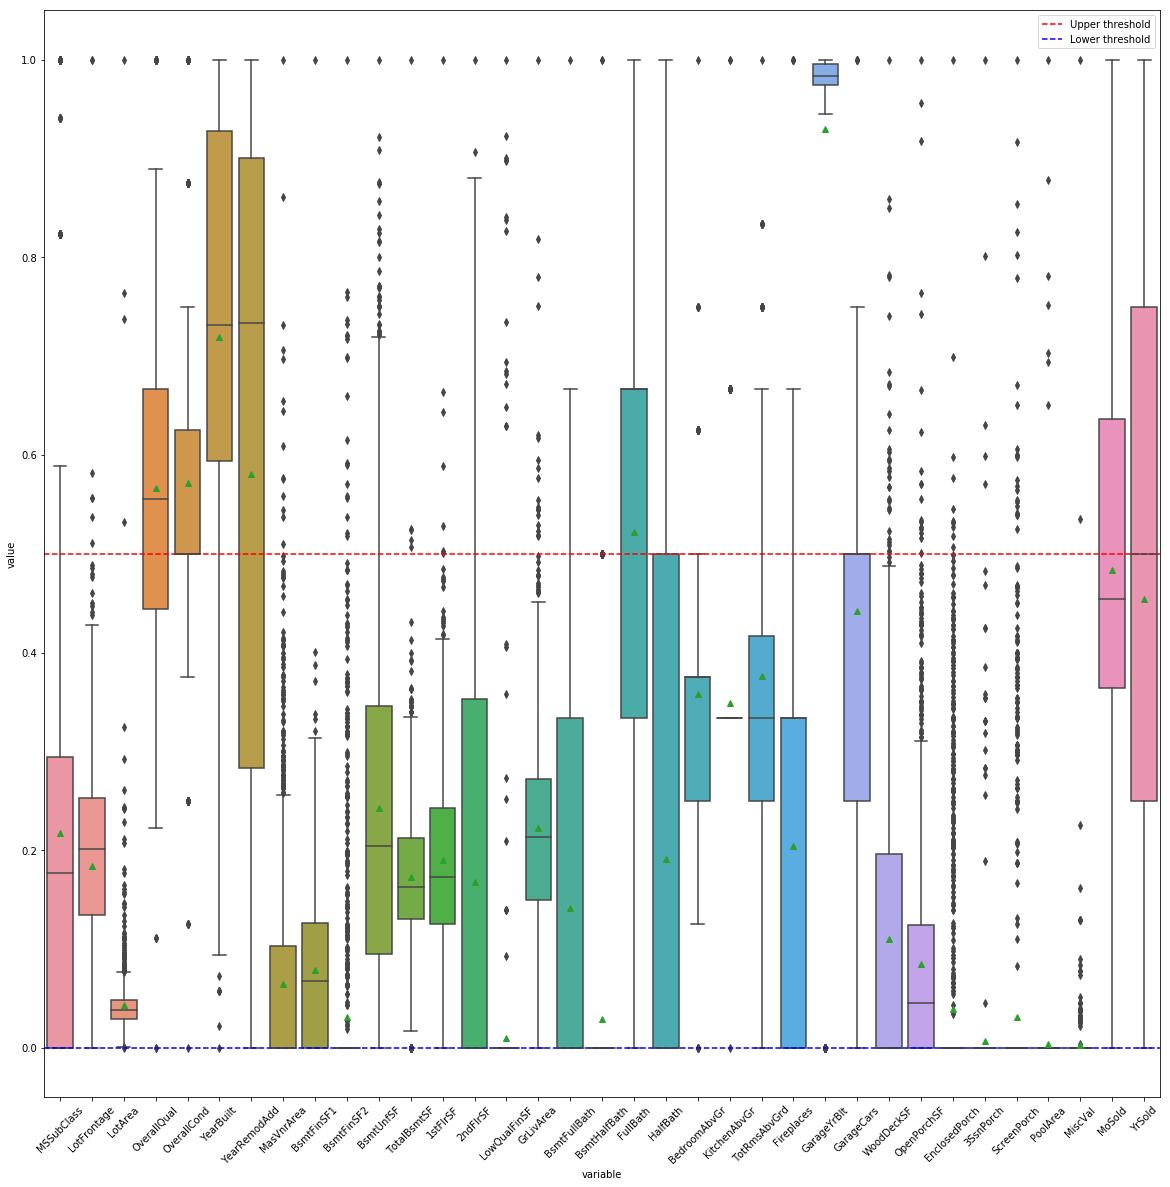

Would you like to increase the plot size for a clear view? - Y/Nn


Plotting outliers for categorical features...




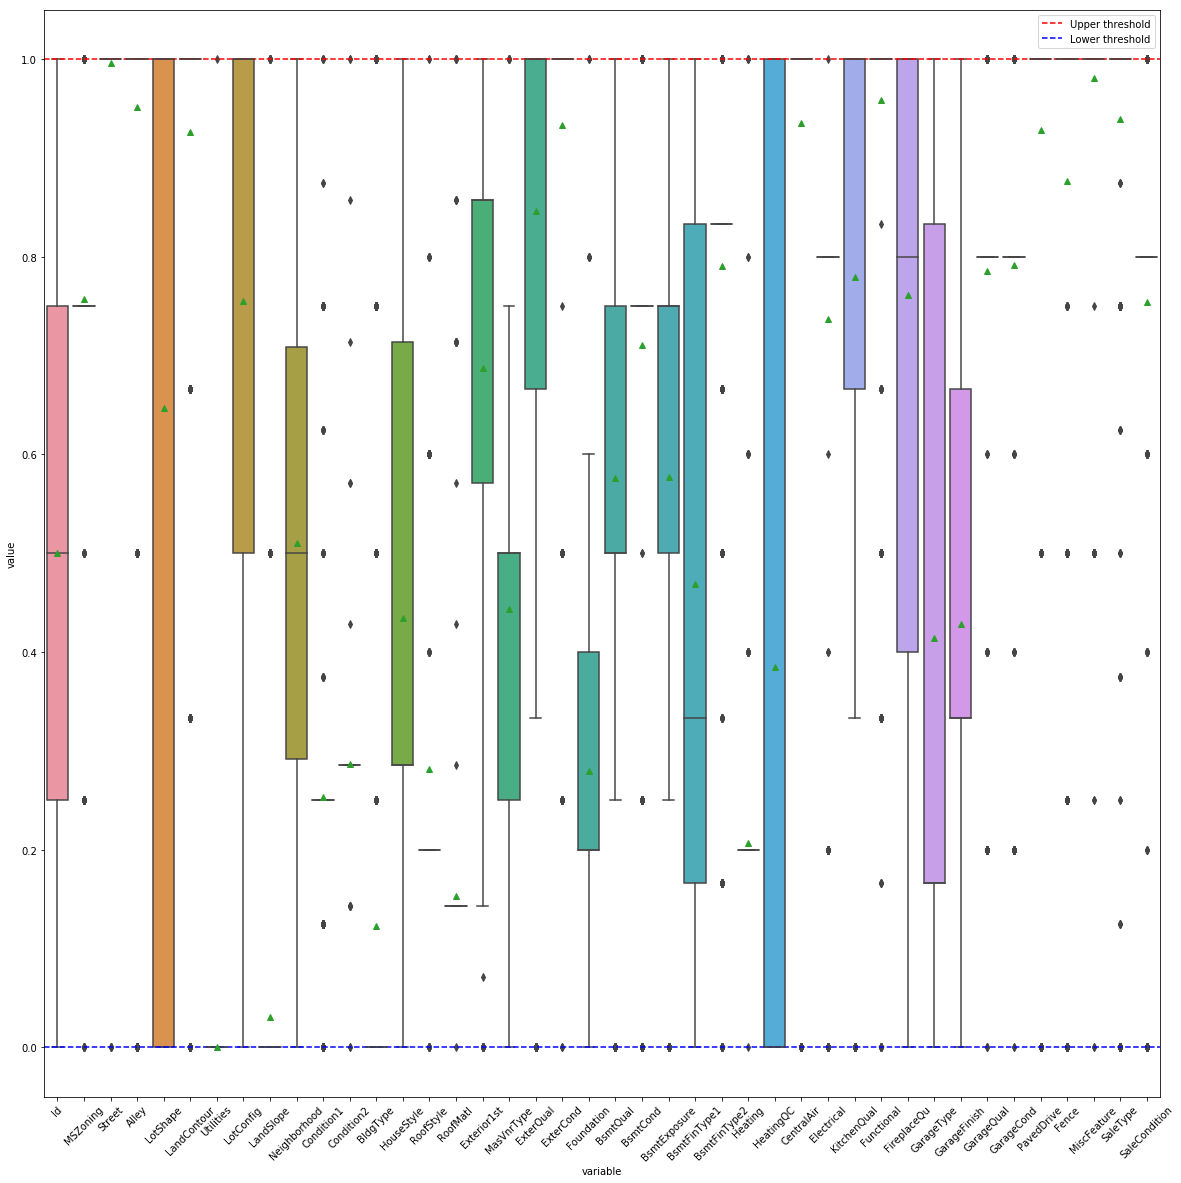

Would you like to increase the plot size for a clear view? - Y/Nn


Plotting outliers for all features...




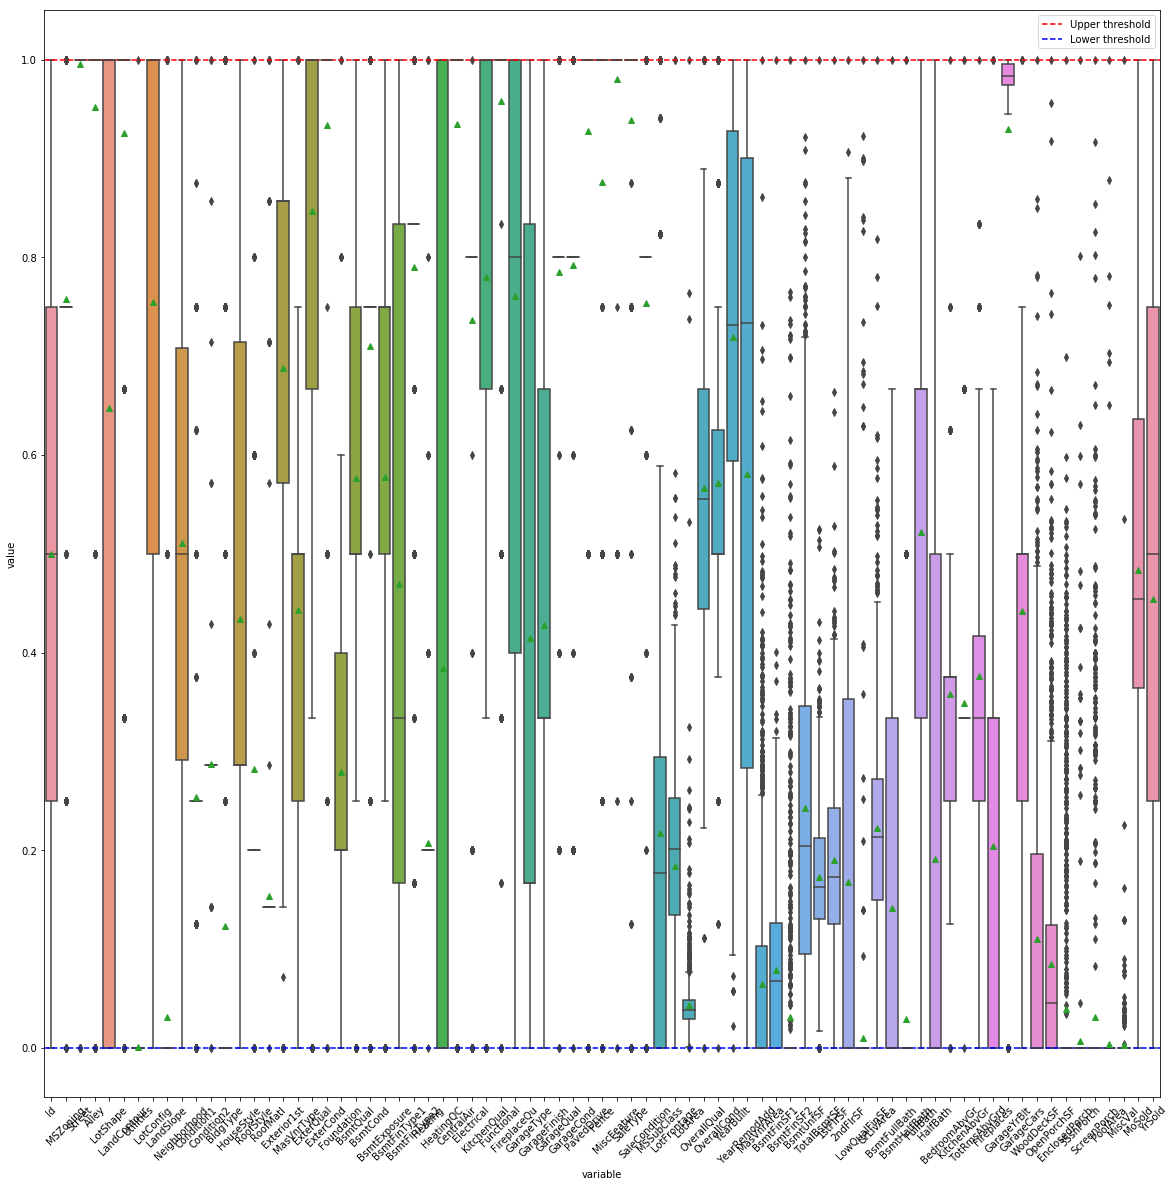

Would you like to increase the plot size for a clear view? - Y/Nn


Would you like to remove any of the outliers? - Y/Nn
Press enter to continue...


''

In [38]:

fig_size_x = 20
fig_size_y = 20

chck_outlier = True
#to_drop=[]
while(chck_outlier == True):
    
    check_outlier = (input('Would you like to check for outliers in the data? - Y/N')).upper()
    if check_outlier == 'Y':
        
        out_cont_features = [i for i in continuous_features  if i not in to_drop+ [target_name]]
        out_cat_features  = [i for i in categorical_features if i not in to_drop+ [target_name]]

        if out_cont_features:
            loop_cont = True
            while(loop_cont==True):
                print("Plotting outliers for continuous features...")
                print('\n')

                #threshold = plotoutliers(data[out_cont_features],fig_size_x,fig_size_y)
                threshold_cont = plotoutliers(data[out_cont_features],fig_size_x,fig_size_y)

                fig_size_change_ind = (input('Would you like to increase the plot size for a clear view? - Y/N')).upper()
                print('\n')

                if fig_size_change_ind =='Y':
                    fig_size_x += 5
                    fig_size_y += 5  
                else:
                    loop_cont = False

        if out_cat_features:
            loop_cat = True
            while(loop_cat == True):
                print("Plotting outliers for categorical features...")
                print('\n')

                #threshold = plotoutliers(data[out_cont_features],fig_size_x,fig_size_y)
                threshold_cat = plotoutliers(data[out_cat_features],fig_size_x,fig_size_y)

                fig_size_change_ind = (input('Would you like to increase the plot size for a clear view? - Y/N')).upper()
                print('\n')

                if fig_size_change_ind =='Y':
                    fig_size_x += 5
                    fig_size_y += 5  
                else:
                    loop_cat = False

        loop_all = True  
        while(loop_all == True):
            print("Plotting outliers for all features...")
            print('\n')
            if not target_is_separate_ind:
                data,target,target_is_separate_ind                     = separate_target(data,target_name)
            threshold_all = plotoutliers(data,fig_size_x,fig_size_y)

            fig_size_change_ind = (input('Would you like to increase the plot size for a clear view? - Y/N')).upper()
            print('\n')

            if fig_size_change_ind =='Y':
                fig_size_x += 5
                fig_size_y += 5
            else:
                loop_all = False

        outlier_remove_ind =  (input("Would you like to remove any of the outliers? - Y/N")).upper()
        if outlier_remove_ind == 'Y':
            if target_is_separate_ind:
                data,target_is_separate_ind       = concatenate_target(data,target)
            invalid_col=True
            while(invalid_col==True):
                col_for_outlier = input("Please enter the feature based on which you would like to remove outliers :")
                print("\n")
                invalid_col_name = validate_columns(data,columnlist = [col_for_outlier])
                if invalid_col_name:
                    print('Warning!! Please verify the feature name and re-enter : ',invalid_col_name)
                    print('\n')
                else:
                    invalid_col=False
            print("Please specify whether you would remove outliers based on Inter quartile range, threshold value or standard deviation")
            removal_method = input("Enter any of these : IQR / threshold / std\n")
            print("\n")
            outlier_thrshld = threshold_all
            if removal_method == 'threshold':
                print("Outliers will be removed based on the displayed threshold of all features unless you would want to change")
                threshld_cat_cont_ind = (input('Would you like to set the threshold based on only continuous or categorical features? - Y/N')).upper()
                if threshld_cat_cont_ind == 'Y':
                    cat_or_cont = (input('Enter A/B for threshold based on continuous/categorical features respectively')).upper()
                    if cat_or_cont == 'A':
                        outlier_thrshld = threshold_cont       
                    elif cat_or_cont =='B':
                        outlier_thrshld = threshold_cat
                else:
                    outlier_threshold_ind = input("Would you like to specify the threshold values for outlier removal? - Y/N")
                    print("\n")
                    if outlier_threshold_ind == 'Y':
                        lower_threshold = input("Enter the lower threshold :")
                        upper_threshold = input("Enter the upper threshold :")
                        print("\n")
                        outlier_thrshld = (lower_threshold,upper_threshold)

            data = remove_outliers(data,column = col_for_outlier,threshold = outlier_thrshld,method = removal_method)
            print("Outliers are successfully removed..")
            print("\n")
        else:
             chck_outlier = False
    else:
         chck_outlier = False
        

    
input("Press enter to continue...")

In [39]:
#Function to plot and obtain feature importance
def feature_imp_plot(df,target,classification,figsize_x=10,figsize_y=25):
    
    #Use random forest with 100 estimators to decide important features
    if classification:
        rnd_clf = RandomForestClassifier(n_estimators = 100 , criterion = 'entropy',random_state = 42)
    else:
        rnd_clf = RandomForestRegressor (n_estimators = 100,random_state = 42)
    
    rnd_clf.fit(df,target)#fit the model
    
    #obtain feature importance along with columns
    x, y = (list(x) for x in zip(*sorted(zip(rnd_clf.feature_importances_, df.columns), reverse = False)))
    #x=[((i-min(x))/(max(x)-min(x)))for i in x]#scale the importances between 0 and 1 for better visualization
    #x=[format(i,'.10f') for i in x]
    fi_df=pd.DataFrame(x,index=y,columns=['Importance'])#create dataframe of feature importance
    
    #plot feature importance
    plt.figure(figsize=(figsize_x, figsize_y))
    ax=plt.barh(np.arange(len(y)), x, align='center', alpha=0.5,color='g',log=True)
    ax=plt.yticks(np.arange(len(y)), y)
    ax=plt.xlabel('Importance')
    
    #for p in ax.patches:
        #plt.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    

    
    return fi_df


Plotting feature importance in log scale of importances...


Please specify if this is a regression problem or classification

Enter R for Regression or C for Classification : r


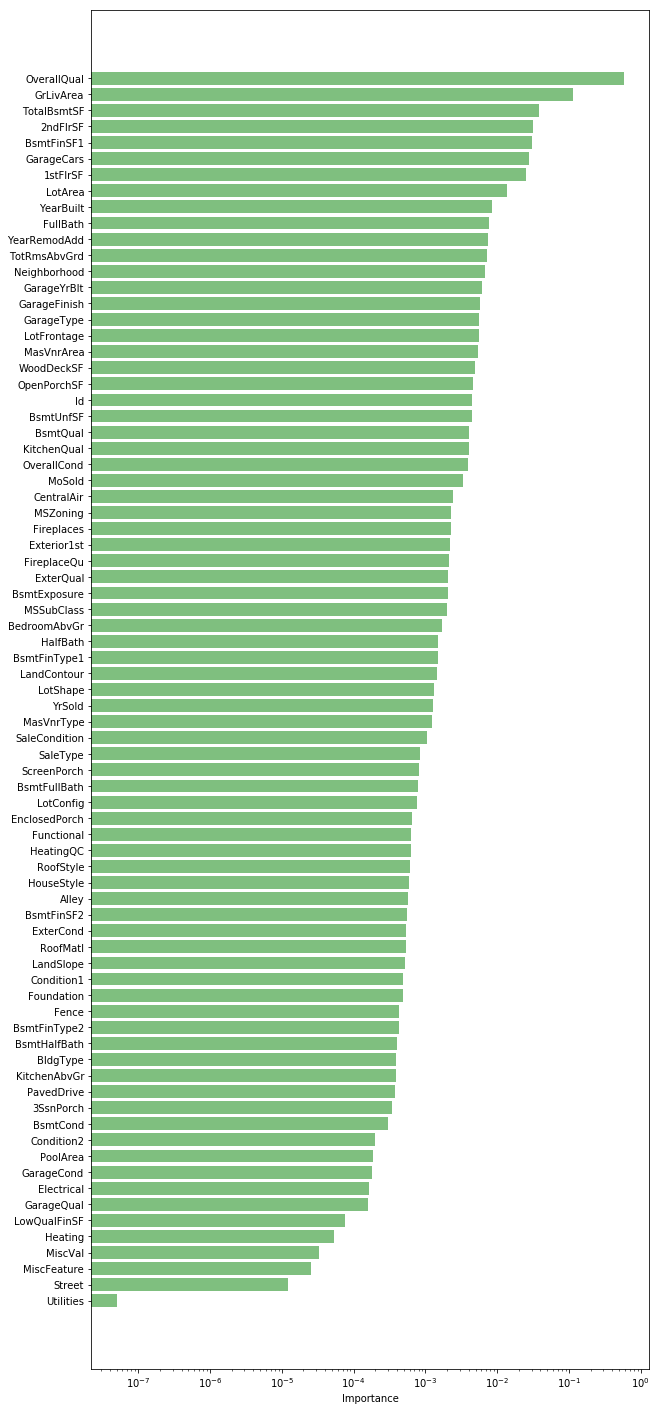

Below is the feature importance for every feature:
                 Importance
OverallQual   5.789756e-01
GrLivArea     1.126616e-01
TotalBsmtSF   3.773057e-02
2ndFlrSF      3.147107e-02
BsmtFinSF1    3.082331e-02
GarageCars    2.730438e-02
1stFlrSF      2.498031e-02
LotArea       1.365943e-02
YearBuilt     8.525150e-03
FullBath      7.605961e-03
YearRemodAdd  7.352976e-03
TotRmsAbvGrd  7.244259e-03
Neighborhood  6.730665e-03
GarageYrBlt   6.159831e-03
GarageFinish  5.778486e-03
GarageType    5.653008e-03
LotFrontage   5.584395e-03
MasVnrArea    5.345705e-03
WoodDeckSF    4.857311e-03
OpenPorchSF   4.598130e-03
Id            4.497421e-03
BsmtUnfSF     4.473166e-03
BsmtQual      4.102250e-03
KitchenQual   4.059068e-03
OverallCond   3.889232e-03
MoSold        3.350158e-03
CentralAir    2.411678e-03
MSZoning      2.297279e-03
Fireplaces    2.241684e-03
Exterior1st   2.209869e-03
...                    ...
Functional    6.366226e-04
HeatingQC     6.208160e-04
RoofStyle     6.103105e-04
Hou

In [40]:
print("Plotting feature importance in log scale of importances...")
print('\n')

print("Please specify if this is a regression problem or classification\n")

while (True):
    reg_or_class = (input("Enter R for Regression or C for Classification : ")).upper()
    if reg_or_class in ['R','C']:
        break

if reg_or_class == 'C':
    class_ind = True
else:
    class_ind = False

if not target_is_separate_ind:
    data,target,target_is_separate_ind                     = separate_target(data,target_name)

data_fi = feature_imp_plot(data,target=target,classification=class_ind)
plt.show()

print("Below is the feature importance for every feature:\n",data_fi.sort_values('Importance', ascending= False))


In [41]:
#Function to obtain the list of unimportant features by referring to feature importance plot and thereby setting threshold
def get_unimp_features(df,threshold):
    
    unimp_features_list = df[(df['Importance'].astype('float64') < np.float64(threshold))].index.values.tolist()

    
    return unimp_features_list
    

In [42]:
drop_features_ind = (input('Would you like to drop unimportant features? - Y/N')).upper()
print('\n')
if drop_features_ind == 'Y':
    fi_threshold = (input('Please refer to the feature importance plot above and enter the threshold below which you would like to drop the features'))
    print('\n')
    unimp_features = get_unimp_features(data_fi,fi_threshold)
    print('Here is the list of unimportant features : ',unimp_features)
    print('\n')
    print('Dropping  all unimportant features ...')
    print('\n')
    for i in unimp_features:
        if i in categorical_features:
            categorical_features.remove(i)
        elif i in continuous_features:
            continuous_features.remove(i)
        elif i in date_features:
            date_features.remove(i) 
    data.drop(unimp_features,axis =1,inplace=True)
    print('Now let us take a look at our dataset with important features only!!\n ')
    display(data.head())
    

Would you like to drop unimportant features? - Y/Ny


Please refer to the feature importance plot above and enter the threshold below which you would like to drop the features4.980618e-08


Here is the list of unimportant features :  ['Utilities']


Dropping  all unimportant features ...


Now let us take a look at our dataset with important features only!!
 


,Id,MSZoning,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.000000,0.75,1.0,1.0,1.0,1.0,1.0,0.0,0.208333,0.250,...,0.50,0.000000,0.111517,0.000000,0.0,0.0,0.0,0.0,0.090909,0.50
1,0.392049,0.75,1.0,1.0,1.0,1.0,0.5,0.0,1.000000,0.125,...,0.50,0.347725,0.000000,0.000000,0.0,0.0,0.0,0.0,0.363636,0.25
2,0.468129,0.75,1.0,1.0,0.0,1.0,1.0,0.0,0.208333,0.250,...,0.50,0.000000,0.076782,0.000000,0.0,0.0,0.0,0.0,0.727273,0.50
3,0.544208,0.75,1.0,1.0,0.0,1.0,0.0,0.0,0.250000,0.250,...,0.75,0.000000,0.063985,0.492754,0.0,0.0,0.0,0.0,0.090909,0.00
4,0.620288,0.75,1.0,1.0,0.0,1.0,0.5,0.0,0.625000,0.250,...,0.75,0.224037,0.153565,0.000000,0.0,0.0,0.0,0.0,1.000000,0.50


In [43]:
##Function to reduce the number of features in the data
def dimreduction(df,reqd_dim):
    
    components_required=min(reqd_dim,len(df.columns)) #if number of features < 30, then reduce dimension to to number of features else to 30
    pca = PCA(n_components = components_required)
    principalComponents = pca.fit_transform(df.iloc[:,:].values)#converting data to array so as to fit
    principalDf = pd.DataFrame(data = principalComponents,index=df.index)#convert compressed data to dataframe
    feature_names=['Feature'+str(i) for i in range(len(principalDf.columns.tolist()))]
    principalDf.columns=feature_names
    return principalDf

In [44]:
dim_red_ind = (input('Would you like to reduce dimensions of the data? - Y/N')).upper()
if dim_red_ind == 'Y':
    no_of_comp = int(input('Please enter the number of dimensions that you would like to reduce to :'))
    data = dimreduction(data,reqd_dim = no_of_comp)
    print('Here is your compressed data..\n')
    display(data.head())

Would you like to reduce dimensions of the data? - Y/Nn


In [45]:
data,target_is_separate_ind       = concatenate_target(data,target)

In [46]:
data.head()

,Id,MSZoning,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,0.000000,0.75,1.0,1.0,1.0,1.0,1.0,0.0,0.208333,0.250,...,0.000000,0.111517,0.000000,0.0,0.0,0.0,0.0,0.090909,0.50,208500
1,0.392049,0.75,1.0,1.0,1.0,1.0,0.5,0.0,1.000000,0.125,...,0.347725,0.000000,0.000000,0.0,0.0,0.0,0.0,0.363636,0.25,181500
2,0.468129,0.75,1.0,1.0,0.0,1.0,1.0,0.0,0.208333,0.250,...,0.000000,0.076782,0.000000,0.0,0.0,0.0,0.0,0.727273,0.50,223500
3,0.544208,0.75,1.0,1.0,0.0,1.0,0.0,0.0,0.250000,0.250,...,0.000000,0.063985,0.492754,0.0,0.0,0.0,0.0,0.090909,0.00,140000
4,0.620288,0.75,1.0,1.0,0.0,1.0,0.5,0.0,0.625000,0.250,...,0.224037,0.153565,0.000000,0.0,0.0,0.0,0.0,1.000000,0.50,250000


In [47]:
DropMoreInd = (input('Would you like to drop any more columns from the list & take backup? Y/N : ')).upper()
print("\n")

if DropMoreInd == 'Y':
    while(True):
        drop_more_column_list = []
        print('Enter the features you wish to drop, separated by comma : ')
        drop_more_column_list = [x for x in input().split(',')]
        print('\n')

        if drop_more_column_list:
            invalid_col_names = validate_columns(data,columnlist = drop_more_column_list)
            if invalid_col_names:
                print('Warning!! Some of the feature names you have entered are incorrect. List of incorrectly entered features are : ',invalid_col_names)
                print('Please verify..')
                print('\n')
            else:
                break 

    df_backup = data[drop_more_column_list]
    data = drop_columns(data,columnlist=drop_more_column_list)
    print('Specified features are successfully dropped & backup taken in df_backup...')
    print('\n')
    print('Existing features in the dataset are: ', data.columns.tolist())
    print('\n')
else:
    pass
    
data.head()

Would you like to drop any more columns from the list & take backup? Y/N : n




,Id,MSZoning,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,0.000000,0.75,1.0,1.0,1.0,1.0,1.0,0.0,0.208333,0.250,...,0.000000,0.111517,0.000000,0.0,0.0,0.0,0.0,0.090909,0.50,208500
1,0.392049,0.75,1.0,1.0,1.0,1.0,0.5,0.0,1.000000,0.125,...,0.347725,0.000000,0.000000,0.0,0.0,0.0,0.0,0.363636,0.25,181500
2,0.468129,0.75,1.0,1.0,0.0,1.0,1.0,0.0,0.208333,0.250,...,0.000000,0.076782,0.000000,0.0,0.0,0.0,0.0,0.727273,0.50,223500
3,0.544208,0.75,1.0,1.0,0.0,1.0,0.0,0.0,0.250000,0.250,...,0.000000,0.063985,0.492754,0.0,0.0,0.0,0.0,0.090909,0.00,140000
4,0.620288,0.75,1.0,1.0,0.0,1.0,0.5,0.0,0.625000,0.250,...,0.224037,0.153565,0.000000,0.0,0.0,0.0,0.0,1.000000,0.50,250000


In [48]:
print("Splitting the data into train and test splits...")
print('\n')
    
number = None
while not number:
    s = input("Enter the test_size in two decimal float like 0.20: ")
    s = s.strip()
    string_number = s.split(".")
    if len(string_number[0]) != 1:
        print ("ERROR: Needs exactly one decimal point!")
        continue
    elif string_number[0] != '0':
        print ("ERROR: Need exactly zero before decimal point!")
        continue
    elif len(string_number[1]) != 2:
        print ("ERROR: Two numbers are required after decimal point!")
        continue
    try:
        number = float(s)
        break
    except ValueError:
        print("ERROR: Number is not valid!")

print('Test size selected as ', number)

# Here the stratified shuffle split is done
X = data.loc[:, data.columns != target.name]
Y = data[target.name]

if class_ind == False:
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=number, random_state=42, shuffle=True)
    print('Regression: Train-Test split done successfully using shuffle train_test_split.')
elif class_ind == True:
    # have used 10 splits and test data proportion equal to 0.3
    sss= StratifiedShuffleSplit(n_splits=10, test_size=number, random_state=42)
    # equating the index of all the shuffled index to the data.
    for train_index, test_index in sss.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]            
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index] 
    print('Classification: Train-Test split done successfully using StratifiedShuffleSplit.')

input ('Enter to continue...')
print ('Train shape => ', 'X_train : ', X_train.shape, '; y_train : ', y_train.shape)
print ('Test shape  => ', 'X_test  : ', X_test.shape, '; y_test   : ', y_test.shape)

Splitting the data into train and test splits...


Enter the test_size in two decimal float like 0.20: 0.10
Test size selected as  0.1
Regression: Train-Test split done successfully using shuffle train_test_split.
Enter to continue...
Train shape =>  X_train :  (1314, 76) ; y_train :  (1314,)
Test shape  =>  X_test  :  (146, 76) ; y_test   :  (146,)


In [49]:
col_desc = {target_name : 'output'}
col_desc

{'SalePrice': 'output'}

In [50]:
if class_ind == False:
    ml_predictor = aml.Predictor(type_of_estimator='regressor', column_descriptions=col_desc, verbose=True, name=None)
    model_names_list = ['GradientBoostingRegressor', 'LinearRegression', 'RandomForestRegressor', 'ExtraTreesRegressor', 
                        'XGBRegressor','DeepLearningRegressor']
#    model_names_list = ['LinearRegression']
    print("Prepared parameters for Regressor Predictor")
elif class_ind == True:
    ml_predictor = aml.Predictor(type_of_estimator='classifier', column_descriptions=col_desc, verbose=True, name=None)
    model_names_list = ['GradientBoostingClassifier', 'LogisticRegression', 'RandomForestClassifier', 'ExtraTreesClassifier', 
                        'XGBClassifier','DeepLearningClassifier']
#    model_names_list = ['LogisticRegression']
    print("Prepared parameters for Classifier Predictor")
else:
    print("Data split was neither based on Regression nor Classification. Please choose correctly!!")

Prepared parameters for Regressor Predictor


In [51]:
data_sample = data.sample(n=min(data.shape[0],500), replace=False, weights=None, random_state=42, axis=None)
print ("Sample Shape: ", data_sample.shape)
data_sample.head()

Sample Shape:  (500, 77)


,Id,MSZoning,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
892,0.919808,0.75,1.0,1.0,1.0,1.000000,1.0,0.0,0.791667,0.250,...,0.224037,0.000000,0.000000,0.0,0.0,0.0,0.0,0.090909,0.00,154500
1105,0.082248,0.75,1.0,1.0,0.0,1.000000,0.0,0.0,0.625000,0.250,...,0.217036,0.058501,0.000000,0.0,0.0,0.0,0.0,0.272727,1.00,325000
413,0.555860,1.00,1.0,0.0,1.0,1.000000,1.0,0.0,0.708333,0.000,...,0.000000,0.000000,0.235507,0.0,0.0,0.0,0.0,0.181818,1.00,115000
522,0.638794,1.00,1.0,1.0,1.0,1.000000,0.0,0.0,0.125000,0.125,...,0.000000,0.043876,0.065217,0.0,0.0,0.0,0.0,0.818182,0.00,159000
1036,0.029472,0.75,1.0,1.0,0.0,0.333333,1.0,0.0,0.958333,0.250,...,0.266044,0.000000,0.000000,0.0,0.0,0.0,0.0,0.727273,0.75,315500


In [52]:
ml_predictor.train(raw_training_data=data_sample, optimize_final_model=False, perform_feature_selection=True, verbose=True, 
                   ml_for_analytics=True, take_log_of_y=None, model_names=model_names_list, 
                   perform_feature_scaling=False, calibrate_final_model=False, verify_features=False, cv=5, 
                   feature_learning=False, fl_data=None, prediction_intervals=False)

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Heard that we should not perform feature_scaling, but we should train a Deep Learning model. Note that feature_scaling is typically useful and frequently essential for deep learning. We STRONGLY suggest not setting perform_feature_scaling=False.
Welcome to auto_ml! We're about to go through and make sense of your data using machine learning, and give you a production-ready pipeline to get predictions with.

If you have any issues, or new feature ideas, let us know at http://auto.ml
You are running on version 2.9.10
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{'presort': False, 'learning_rate': 0.1, 'warm_start': True}


C:\ProgramData\Anaconda3\lib\site-packages\auto_ml\predictor.py:378: UserWarning: It is a best practice, and often necessary for training, to perform_feature_scaling while doing Deep Learning.
  warnings.warn('It is a best practice, and often necessary for training, to perform_feature_scaling while doing Deep Learning.')


Running basic data cleaning
Fitting DataFrameVectorizer
Performing feature selection


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{'presort': False, 'learning_rate': 0.1, 'warm_start': True}


********************************************************************************************
About to run GridSearchCV on the pipeline for several models to predict SalePrice
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   17.0s finished


The best CV score from our hyperparameter search (by default averaging across k-fold CV) for SalePrice is:
-28793.59936517705
The best params were
{'model': 'XGBRegressor'}
Here are all the hyperparameters that were tried:
Score in the following columns always refers to cross-validation score
+------------------+
|       mean_score |
|------------------|
| -1000000000.0000 |
|      -42880.9117 |
|      -31642.2200 |
|      -30473.3719 |
|      -30342.3866 |
|      -28793.5994 |
+------------------+
Calculating feature responses, for advanced analytics.
Here are our feature responses for the trained model
+----+----------------+---------+-------------------+-------------------+------------+------------+
|    | Feature Name   |   Delta |   FR_Decrementing |   FR_Incrementing |    FRD_MAD |    FRI_MAD |
|----+----------------+---------+-------------------+-------------------+------------+------------|
| 12 | LotShape       |  0.2330 |            0.0000 |            0.0000 |     0.0000 |  

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

In [53]:
final_model=input('Please enter the best model that was chosen : ')

Please enter the best model that was chosen : XGBRegressor


In [54]:
if class_ind == False:
    X_training, X_featurelearning, y_training, y_featurelearning = train_test_split(X_train, y_train, test_size=0.1, random_state=42, shuffle=True)
elif class_ind == True:# have used 10 splits and test data proportion equal to 0.3
    sss= StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=42)
    # equating the index of all the shuffled index to the data.
    for train_index, fl_index in sss.split(X_train, y_train):
        X_training, X_featurelearning = X_train.iloc[train_index], X_train.iloc[fl_index]            
        y_training, y_featurelearning = y_train.iloc[train_index], y_train.iloc[fl_index] 

In [55]:
df_train         = pd.concat([X_training, y_training], axis=1)
df_feature_learn = pd.concat([X_featurelearning, y_featurelearning], axis=1)
df_test          = pd.concat([X_test, y_test], axis=1)

In [56]:
df_train.shape

(1182, 77)

In [104]:
if final_model in ['DeepLearningClassifier','DeepLearningRegressor']:
    trained_model = ml_predictor.train(raw_training_data=df_train, perform_feature_selection=True, model_names=final_model,cv=5,
                   perform_feature_scaling=False,optimize_final_model=True)
else:
    trained_model = ml_predictor.train(raw_training_data=df_train, perform_feature_selection=False, model_names=final_model,cv=5,
                   perform_feature_scaling=False, feature_learning=True, fl_data=df_feature_learn,optimize_final_model=False)
    

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Heard that we should not perform feature_scaling, but we should train a Deep Learning model. Note that feature_scaling is typically useful and frequently essential for deep learning. We STRONGLY suggest not setting perform_feature_scaling=False.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Heard that we should not perform feature_scaling, but we should perform feature_learning. Note that feature_scaling is typically useful for deep learning, which is what we use for feature_learning. If you want a little more model accuracy from the feature_learning step, consider not passing in perform_feature_scaling=False
Welcome to auto_ml! We're about to go through and make sense of your data using machine learning, and give you a production-ready pipeline to get predictions with.

If you have any issues, or new feature ideas, let us know at http://auto.ml
You are running on version 2.9.10


C:\ProgramData\Anaconda3\lib\site-packages\auto_ml\predictor.py:378: UserWarning: It is a best practice, and often necessary for training, to perform_feature_scaling while doing Deep Learning.
  warnings.warn('It is a best practice, and often necessary for training, to perform_feature_scaling while doing Deep Learning.')
C:\ProgramData\Anaconda3\lib\site-packages\auto_ml\predictor.py:516: UserWarning: Consider allowing auto_ml to perform_feature_scaling in conjunction with feature_learning
  warnings.warn('Consider allowing auto_ml to perform_feature_scaling in conjunction with feature_learning')


Running basic data cleaning
Fitting DataFrameVectorizer


********************************************************************************************
About to fit the pipeline for the model DeepLearningRegressor to predict SalePrice
Started at:
2018-12-19 18:16:10

We will stop training early if we have not seen an improvement in validation accuracy in 25 epochs
To measure validation accuracy, we will split off a random 10 percent of your training data set
Train on 112 samples, validate on 20 samples
Epoch 1/1000
 - 2s - loss: 36361396150.8571 - mean_absolute_error: 175755.7123 - mean_absolute_percentage_error: 100.0000 - val_loss: 29871243264.0000 - val_mean_absolute_error: 162442.5000 - val_mean_absolute_percentage_error: 100.0000
Epoch 2/1000
 - 0s - loss: 36361396553.1429 - mean_absolute_error: 175755.7201 - mean_absolute_percentage_error: 100.0000 - val_loss: 29871239168.0000 - val_mean_absolute_error: 162442.5000 - val_mean_absolute_percentage_error: 100.0000
Epoch 3/1000
 - 0s 

Epoch 34/1000
 - 0s - loss: 24390894665.1429 - mean_absolute_error: 137977.4414 - mean_absolute_percentage_error: 74.6894 - val_loss: 17501345792.0000 - val_mean_absolute_error: 118624.7266 - val_mean_absolute_percentage_error: 69.2440
Epoch 35/1000
 - 0s - loss: 22227991990.8571 - mean_absolute_error: 129742.5382 - mean_absolute_percentage_error: 69.0641 - val_loss: 15375920128.0000 - val_mean_absolute_error: 109339.2031 - val_mean_absolute_percentage_error: 62.7260
Epoch 36/1000
 - 0s - loss: 19721745261.7143 - mean_absolute_error: 120271.1095 - mean_absolute_percentage_error: 63.1694 - val_loss: 13119220736.0000 - val_mean_absolute_error: 98528.9219 - val_mean_absolute_percentage_error: 55.1393
Epoch 37/1000
 - 0s - loss: 17080581138.2857 - mean_absolute_error: 109394.8146 - mean_absolute_percentage_error: 56.4273 - val_loss: 10798254080.0000 - val_mean_absolute_error: 86570.5781 - val_mean_absolute_percentage_error: 47.1040
Epoch 38/1000
 - 0s - loss: 14352659858.2857 - mean_absolu

Epoch 70/1000
 - 0s - loss: 3263818838.8571 - mean_absolute_error: 41983.8280 - mean_absolute_percentage_error: 28.7394 - val_loss: 2384149760.0000 - val_mean_absolute_error: 40646.0234 - val_mean_absolute_percentage_error: 31.6356
Epoch 71/1000
 - 0s - loss: 3201529718.8571 - mean_absolute_error: 41598.3723 - mean_absolute_percentage_error: 28.2399 - val_loss: 2359892480.0000 - val_mean_absolute_error: 40534.8398 - val_mean_absolute_percentage_error: 31.6837
Epoch 72/1000
 - 0s - loss: 3110425131.4286 - mean_absolute_error: 40983.2794 - mean_absolute_percentage_error: 27.7896 - val_loss: 2539001344.0000 - val_mean_absolute_error: 42925.1719 - val_mean_absolute_percentage_error: 34.1562
Epoch 73/1000
 - 0s - loss: 3205748603.4286 - mean_absolute_error: 43219.6618 - mean_absolute_percentage_error: 29.9064 - val_loss: 2215016960.0000 - val_mean_absolute_error: 38854.1016 - val_mean_absolute_percentage_error: 30.0251
Epoch 74/1000
 - 0s - loss: 2978222326.8571 - mean_absolute_error: 40050

Epoch 106/1000
 - 0s - loss: 1166665896.0000 - mean_absolute_error: 23182.8218 - mean_absolute_percentage_error: 13.3267 - val_loss: 814472704.0000 - val_mean_absolute_error: 23597.8867 - val_mean_absolute_percentage_error: 16.2581
Epoch 107/1000
 - 0s - loss: 1065234818.2857 - mean_absolute_error: 22449.4553 - mean_absolute_percentage_error: 13.2867 - val_loss: 793005248.0000 - val_mean_absolute_error: 22999.9805 - val_mean_absolute_percentage_error: 15.7115
Epoch 108/1000
 - 0s - loss: 1032638195.4286 - mean_absolute_error: 22455.7136 - mean_absolute_percentage_error: 13.4237 - val_loss: 862067904.0000 - val_mean_absolute_error: 24779.6133 - val_mean_absolute_percentage_error: 17.1757
Epoch 109/1000
 - 0s - loss: 1028874064.0000 - mean_absolute_error: 22491.4412 - mean_absolute_percentage_error: 13.5414 - val_loss: 775381440.0000 - val_mean_absolute_error: 22416.2129 - val_mean_absolute_percentage_error: 15.1367
Epoch 110/1000
 - 0s - loss: 1032989770.2857 - mean_absolute_error: 2199

Epoch 142/1000
 - 0s - loss: 655428110.2857 - mean_absolute_error: 19084.4909 - mean_absolute_percentage_error: 12.1435 - val_loss: 813923840.0000 - val_mean_absolute_error: 23211.1777 - val_mean_absolute_percentage_error: 15.4139
Epoch 143/1000
 - 0s - loss: 769937398.8571 - mean_absolute_error: 21024.9271 - mean_absolute_percentage_error: 13.2741 - val_loss: 713669760.0000 - val_mean_absolute_error: 20472.4180 - val_mean_absolute_percentage_error: 12.9733
Epoch 144/1000
 - 0s - loss: 751869184.0000 - mean_absolute_error: 20644.2381 - mean_absolute_percentage_error: 12.9154 - val_loss: 746437312.0000 - val_mean_absolute_error: 20427.6621 - val_mean_absolute_percentage_error: 12.7883
Epoch 145/1000
 - 0s - loss: 644405346.2857 - mean_absolute_error: 18813.0273 - mean_absolute_percentage_error: 11.9161 - val_loss: 734280320.0000 - val_mean_absolute_error: 21648.2969 - val_mean_absolute_percentage_error: 14.0017
Epoch 146/1000
 - 0s - loss: 699341130.2857 - mean_absolute_error: 19488.996

Epoch 178/1000
 - 0s - loss: 596491084.0000 - mean_absolute_error: 18358.9865 - mean_absolute_percentage_error: 11.5237 - val_loss: 1127466240.0000 - val_mean_absolute_error: 26654.4648 - val_mean_absolute_percentage_error: 16.5711
Epoch 179/1000
 - 0s - loss: 643636600.0000 - mean_absolute_error: 19264.5218 - mean_absolute_percentage_error: 11.5423 - val_loss: 713277696.0000 - val_mean_absolute_error: 19961.3984 - val_mean_absolute_percentage_error: 12.0178
Epoch 180/1000
 - 0s - loss: 549943528.0000 - mean_absolute_error: 17117.5349 - mean_absolute_percentage_error: 10.6234 - val_loss: 669369728.0000 - val_mean_absolute_error: 20423.6133 - val_mean_absolute_percentage_error: 13.2041
Epoch 181/1000
 - 0s - loss: 551075480.0000 - mean_absolute_error: 17726.8681 - mean_absolute_percentage_error: 11.0950 - val_loss: 755224896.0000 - val_mean_absolute_error: 20685.8613 - val_mean_absolute_percentage_error: 12.5147
Epoch 182/1000
 - 0s - loss: 493056426.2857 - mean_absolute_error: 17042.66

Epoch 214/1000
 - 0s - loss: 593306902.8571 - mean_absolute_error: 19111.4954 - mean_absolute_percentage_error: 11.8362 - val_loss: 693660160.0000 - val_mean_absolute_error: 19668.7617 - val_mean_absolute_percentage_error: 12.3492
Epoch 215/1000
 - 0s - loss: 582073132.0000 - mean_absolute_error: 18973.4665 - mean_absolute_percentage_error: 12.0110 - val_loss: 963513664.0000 - val_mean_absolute_error: 24343.6367 - val_mean_absolute_percentage_error: 15.5644
Epoch 216/1000
 - 0s - loss: 572593146.2857 - mean_absolute_error: 18719.1616 - mean_absolute_percentage_error: 11.8508 - val_loss: 671186496.0000 - val_mean_absolute_error: 19512.5117 - val_mean_absolute_percentage_error: 12.3008
Epoch 217/1000
 - 0s - loss: 527352488.0000 - mean_absolute_error: 17910.8994 - mean_absolute_percentage_error: 11.4786 - val_loss: 653488320.0000 - val_mean_absolute_error: 19556.6523 - val_mean_absolute_percentage_error: 12.4999
Epoch 218/1000
 - 0s - loss: 460075083.4286 - mean_absolute_error: 16798.744

Epoch 250/1000
 - 0s - loss: 454062508.5714 - mean_absolute_error: 16501.8740 - mean_absolute_percentage_error: 10.3773 - val_loss: 643129920.0000 - val_mean_absolute_error: 19155.1523 - val_mean_absolute_percentage_error: 12.1476
Epoch 251/1000
 - 0s - loss: 406320921.7143 - mean_absolute_error: 15510.2748 - mean_absolute_percentage_error: 9.9251 - val_loss: 763805568.0000 - val_mean_absolute_error: 21994.2559 - val_mean_absolute_percentage_error: 14.7525
Epoch 252/1000
 - 0s - loss: 568194369.7143 - mean_absolute_error: 19309.8411 - mean_absolute_percentage_error: 12.6545 - val_loss: 650028160.0000 - val_mean_absolute_error: 19172.0547 - val_mean_absolute_percentage_error: 12.0307
Epoch 253/1000
 - 0s - loss: 474308234.8571 - mean_absolute_error: 17436.3197 - mean_absolute_percentage_error: 11.1099 - val_loss: 716012544.0000 - val_mean_absolute_error: 20424.0586 - val_mean_absolute_percentage_error: 12.7589
Epoch 254/1000
 - 0s - loss: 478051678.8571 - mean_absolute_error: 17680.3945

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '
C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{}


********************************************************************************************
About to fit the pipeline for the model XGBRegressor to predict SalePrice
Started at:
2018-12-19 18:16:41
Finished training the pipeline!
Total training time:
0:00:01


Here are the results from our XGBRegressor
predicting SalePrice
Calculating feature responses, for advanced analytics.
The printed list will only contain at most the top 100 features.
+----+---------------------+--------------+-----------+-------------------+-------------------+------------+------------+------------+------------+
|    | Feature Name        |   Importance |     Delta |   FR_Decrementing |   FR_Incrementing |    FRD_abs |    FRI_abs |    FRD_MAD |    FRI_MAD |
|----+---------------------+--------------+-----------+-------------------+-

In [105]:
from sklearn.externals import joblib

In [106]:
filename = 'finalized_model.sav'
joblib.dump(trained_model, filename)

loaded_model = joblib.load(filename)

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [108]:
# save the model to disk
filename = 'finalized_model.pkl'
pickle.dump(trained_model, open('finalized_model.pkl', "wb"))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [107]:
# Score the model on test data
test_score = loaded_model.score(X_test, y_test)

None


***********************************************
Advanced scoring metrics for the trained regression model on this particular dataset:

Here is the overall RMSE for these predictions:
28786.218614486235

Here is the average of the predictions:
182440.41026327055

Here is the average actual value on this validation set:
182869.34931506848

Here is the median prediction:
153999.8828125

Here is the median actual value:
153950.0

Here is the mean absolute error:
17847.421821489726

Here is the median absolute error (robust to outliers):
10903.03515625

Here is the explained variance:
0.9093252649509838

Here is the R-squared value:
0.9093051274919051
Count of positive differences (prediction > actual):
74
Count of negative differences:
72
Average positive difference:
17183.09786739865
Average negative difference:
-18530.19921875


***********************************************


